The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(187, 31, 31)
(187, 12)
(187, 151, 31, 31)


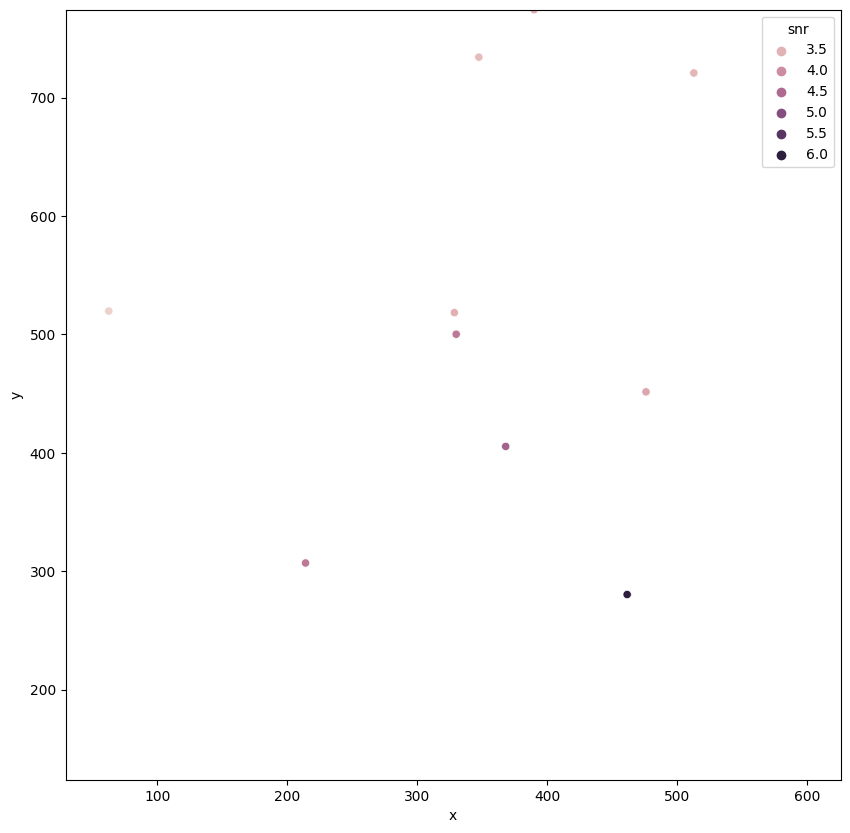

In [159]:
%load_ext autoreload
%autoreload 2
import pandas as pd

import sys
from tifffile import imread
import h5py
import numpy as np

sys.path.append('/home/miguel/Projects/uni/phd/smlm_z/smlm-z/src/smlm_z/pipelines')
try:
    from preprocessing.nodes import extract_training_stacks
except ImportError:
    from preprocessing.nodes import extract_training_stacks

bead_stacks = [
    '/home/miguel/Projects/uni/data/smlm_3d/20230331_beads/3um_stack_20nm_step_20nm_bead_5/3um_stack_20nm_step_20nm_bead_5_MMStack_Default.ome.tif',
#     '/home/miguel/Projects/uni/data/smlm_3d/20230331_beads/3um_stack_20nm_step_20nm_bead_3/3um_stack_20nm_step_20nm_bead_3_MMStack_Default.ome.tif',
#     '/home/miguel/Projects/uni/data/smlm_3d/20230331_beads/3um_stack_20nm_step_20nm_bead_9/3um_stack_20nm_step_20nm_bead_9_MMStack_Default.ome.tif',
#     '/home/miguel/Projects/uni/data/smlm_3d/20230331_beads/3um_stack_20nm_step_20nm_bead_7/3um_stack_20nm_step_20nm_bead_7_MMStack_Default.ome.tif',
#     '/home/miguel/Projects/uni/data/smlm_3d/20230331_beads/3um_stack_20nm_step_20nm_bead_6/3um_stack_20nm_step_20nm_bead_6_MMStack_Default.ome.tif',
#     '/home/miguel/Projects/uni/data/smlm_3d/20230331_beads/3um_stack_20nm_step_20nm_bead_2/3um_stack_20nm_step_20nm_bead_2_MMStack_Default.ome.tif',
#     '/home/miguel/Projects/uni/data/smlm_3d/20230331_beads/3um_stack_20nm_step_20nm_bead_4/3um_stack_20nm_step_20nm_bead_4_MMStack_Default.ome.tif',
#     '/home/miguel/Projects/uni/data/smlm_3d/20230331_beads/3um_stack_20nm_step_20nm_bead_8/3um_stack_20nm_step_20nm_bead_8_MMStack_Default.ome.tif',
]

all_spots = []
all_locs = []
all_stacks = []
for bead_stack_path in bead_stacks:
    bead_stack = imread(bead_stack_path)
    slice_path = bead_stack_path.replace('.ome', '_slice.ome')
    spots_path = slice_path.replace('.tif', '_spots.hdf5')
    with h5py.File(spots_path) as f:
        spots = np.array(f['spots'])

    locs_path = spots_path.replace('_spots', '_locs')
    locs = pd.read_hdf(locs_path, key='locs')

    from skimage.feature import match_template

    parameters = {
        'picasso': {
            'spot_size': 31,
            'localised_frame': bead_stack.shape[0]//2
        },
        'DEBUG': False
    }
    stacks = extract_training_stacks(spots, bead_stack, parameters)
    
    all_spots.append(spots)
    all_locs.append(locs)
    all_stacks.append(stacks)

min_stack_length = min(list(map(lambda s: s.shape[1], all_stacks)))
all_stacks = [s[:, :min_stack_length] for s in all_stacks]

spots = np.concatenate(all_spots)
locs = pd.concat(all_locs)
stacks = np.concatenate(all_stacks)

print(spots.shape)
print(locs.shape)
print(stacks.shape)
max_pixel_val = np.max(stacks, axis=(1,2,3))
mean_pixel_val = np.median(stacks, axis=(1,2,3))
snr = max_pixel_val / mean_pixel_val
locs['snr'] = snr

locs = locs.reset_index(drop=True)

# for i in np.argsort(snr):
#     if snr[i] > 3:
#         show_psf_axial(stacks[i], snr[i])
    
import seaborn as sns
sns.scatterplot(data=locs[locs['snr'] > 3], x='x', y='y', hue='snr')
plt.xlim(locs['x'].min(), locs['x'].max())
plt.ylim(locs['y'].min(), locs['y'].max())
plt.show()


idx = locs['snr'] > 3
locs = locs[idx]
spots = spots[idx]
stacks = stacks[idx]




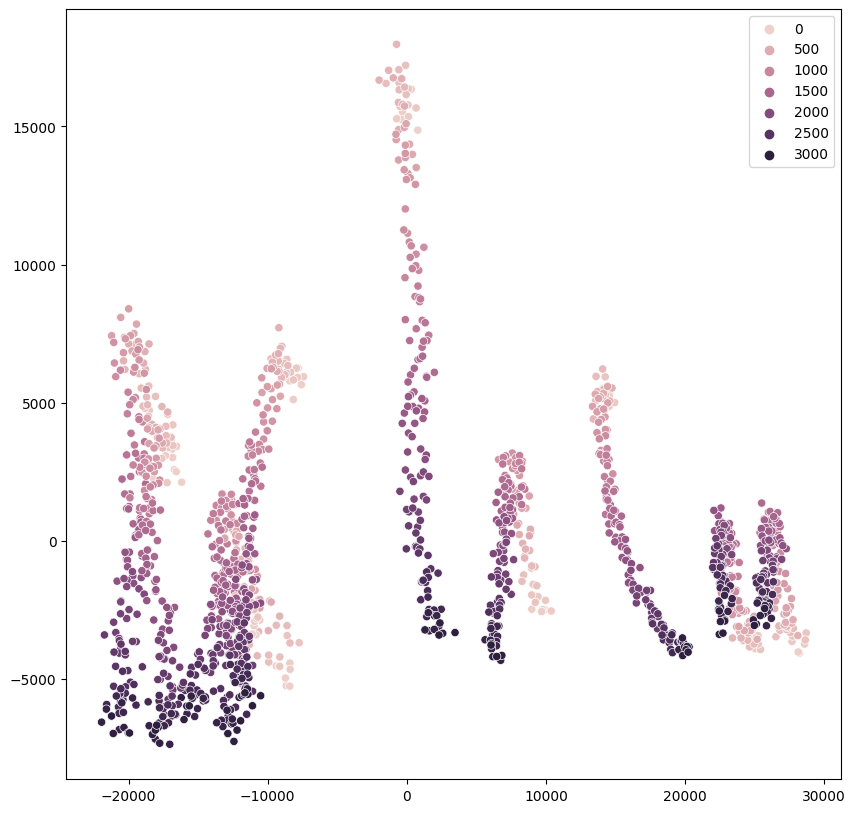

In [161]:
stacks.shape
zs = np.arange(0, stacks.shape[1])*20

zs = np.repeat(zs[np.newaxis], axis=0, repeats=stacks.shape[0])

stacks_flat = np.concatenate(stacks)
stacks_flat = stacks_flat.reshape((stacks_flat.shape[0], -1))
zs = np.concatenate(zs)

from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA().fit_transform(stacks_flat)
sns.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=zs)
plt.show()

In [169]:
lam = 0.625
NA = 1.3

N = 32

cutoff = (2*NA)/lam
print(cutoff)

pixel_size=0.110
magnification=111.11
dx = pixel_size/magnification

freq_space_sampling = 1/(32*dx)

print(freq_space_sampling)


4.16
31.56534090909091


0.004094488188976378
(151, 31, 31)


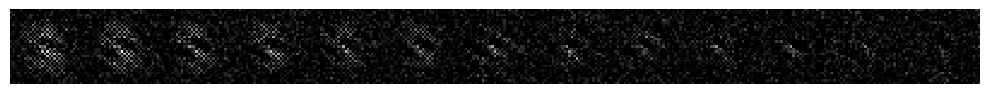

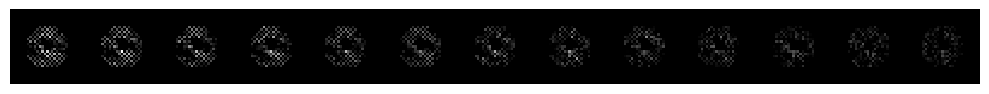

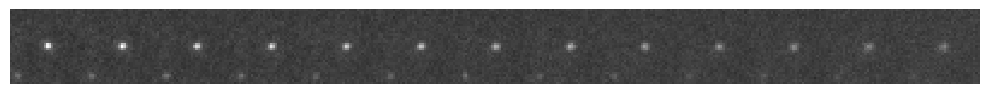

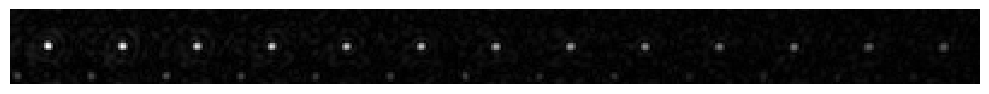

array([[[ 115.90567155,  112.25069316,   77.01303956, ...,
           19.5000796 ,   42.10949633,   74.64866853],
        [  48.40139875,  130.15245395,  141.60221554, ...,
          426.20675694,  273.01113683,  117.51375895],
        [ 114.23301906,  219.19198706,  218.39459536, ...,
          989.46912797,  624.01412612,  209.68615637],
        ...,
        [  99.07286089,   25.2059058 ,   21.20101448, ...,
           67.32810897,   28.69881833,  155.9128864 ],
        [  84.03734624,   55.24389539,   63.05228552, ...,
           58.48771974,   11.23252066,  124.04985388],
        [ 146.10934853,   49.8195646 ,    3.85064649, ...,
           72.39702199,   81.07059773,  157.31927687]],

       [[ 242.8070488 ,   84.96981991,   66.67330754, ...,
          216.94703747,   39.70211435,  195.85268887],
        [ 324.02973675,  295.63343445,  201.32068581, ...,
          618.01745965,  200.64322706,  180.11995875],
        [ 164.43661273,  200.70130964,  265.53053501, ...,
         1022.

In [173]:
from numpy.fft import fftn, fftshift, ifftn, ifftshift

plt.rcParams["figure.figsize"] = (1, 1)


img = stacks[1]
show_psf_axial(img)

def mask_psf(img, r0, r1):
    def create_circular_mask(h, w, center=None, radius=None):
        if center is None: # use the middle of the image
            center = (int(w/2), int(h/2))
        if radius is None: # use the smallest distance between the center and image walls
            radius = min(center[0], center[1], w-center[0], h-center[1])

        Y, X = np.ogrid[:h, :w]
        dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2).astype(int)

        mask = dist_from_center <= radius
        return mask

    fft = fftshift(fftn(img, axes=(1,2)), axes=(1,2))
    print(threshold)

    print(fft.shape)
    mask = create_circular_mask(*fft.shape[1:], radius=r1)
    mask[create_circular_mask(*fft.shape[1:], radius=r0)] = False
    plt.rcParams["figure.figsize"] = (10, 10)
    show_psf_axial(np.imag(fft))
    fft[:, ~mask] = 0
    show_psf_axial(np.imag(fft))

    img2 = np.abs(ifftn(ifftshift(fft, axes=(1,2)), axes=(1,2)))
    show_psf_axial(img)
    show_psf_axial(img2)
    return img2

mask_psf(img, 1, 8.16)


[0.96480894 0.09213115 0.09213115 0.63148165 0.63148165 0.03519115
 0.03519115 0.24120297 0.24120297 0.36852548]
[0.96480894 0.09213115 0.09213115 0.63148165 0.63148165 0.03519115
 0.03519115 0.24120297 0.24120297 0.36852548]
[0.96480894 0.09213115 0.09213115 0.63148165 0.63148165 0.03519115
 0.03519115 0.24120297 0.24120297 0.36852548]
[0.96480894 0.09213115 0.09213115 0.63148165 0.63148165 0.03519115
 0.03519115 0.24120297 0.24120297 0.36852548]
[0.96480894 0.09213115 0.09213115 0.63148165 0.63148165 0.03519115
 0.03519115 0.24120297 0.24120297 0.36852548]
[0.96480894 0.09213115 0.09213115 0.63148165 0.63148165 0.03519115
 0.03519115 0.24120297 0.24120297 0.36852548]
[0.96480894 0.09213115 0.09213115 0.63148165 0.63148165 0.03519115
 0.03519115 0.24120297 0.24120297 0.36852548]
[0.96480894 0.09213115 0.09213115 0.63148165 0.63148165 0.03519115
 0.03519115 0.24120297 0.24120297 0.36852548]
[0.96480894 0.09213115 0.09213115 0.63148165 0.63148165 0.03519115
 0.03519115 0.24120297 0.2412

[0.96480894 0.09213115 0.09213115 0.63148165 0.63148165 0.03519115
 0.03519115 0.24120297 0.24120297 0.36852548]
[0.96480894 0.09213115 0.09213115 0.63148165 0.63148165 0.03519115
 0.03519115 0.24120297 0.24120297 0.36852548]
[0.96480894 0.09213115 0.09213115 0.63148165 0.63148165 0.03519115
 0.03519115 0.24120297 0.24120297 0.36852548]
[0.96480894 0.09213115 0.09213115 0.63148165 0.63148165 0.03519115
 0.03519115 0.24120297 0.24120297 0.36852548]
[0.96480894 0.09213115 0.09213115 0.63148165 0.63148165 0.03519115
 0.03519115 0.24120297 0.24120297 0.36852548]
[0.96480894 0.09213115 0.09213115 0.63148165 0.63148165 0.03519115
 0.03519115 0.24120297 0.24120297 0.36852548]
[0.96480894 0.09213115 0.09213115 0.63148165 0.63148165 0.03519115
 0.03519115 0.24120297 0.24120297 0.36852548]
[0.96480894 0.09213115 0.09213115 0.63148165 0.63148165 0.03519115
 0.03519115 0.24120297 0.24120297 0.36852548]
[0.96480894 0.09213115 0.09213115 0.63148165 0.63148165 0.03519115
 0.03519115 0.24120297 0.2412

/home/miguel/Projects/uni/venv/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


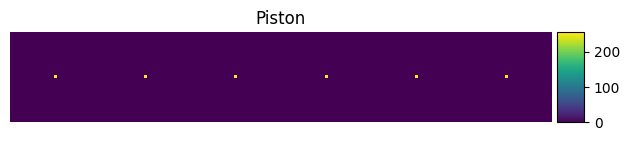

Time taken: 5.059s


In [75]:
from data.visualise import grid_psfs, show_psf_axial

import os

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.01'

import jax.numpy as jnp
import jax
import numpy as np

def rms2(ab, pupil):
    return np.sqrt(np.sum(ab**2) / np.sum(pupil <= 1))


try:
    import cupy as cp

    print('cupy imported')
    import_cp = True
except:
    import_cp = False

import matplotlib.pyplot as plt

from jax import jit

def rms(pupil):
    return jnp.sqrt(jnp.mean(jnp.abs(pupil)**2))
          
def norm_zero_one(psf):
    return (psf - psf.min()) / (psf.max() - psf.min())


import poppy 

KR = None
THETA = None
class Simulator:
    
    
# pixel size (nm) - 115
# step size (nm) - 20nm
# magnification - 100x
# illumination NA
# NA at sample
# refractive index at sample - PBS so 1.335
# illumination wavelength - 635nm
# detection wavelength - to check


# #     N = 2048  # points to use in FFT
#     Nn = 32
#     pixel_size = 0.115  # camera pixel size
#     zrange = 1.0  # distance either side of focus to calculate, in microns, could be arbitrary
#     dz = 0.02  # step size in axial direction of PSF
    
#     magnification = 100  # objective magnification
#     ill_NA = 1.4  # numerical aperture at illumination beams
#     det_NA = 1.1  # numerical aperture at sample
#     n = 1.335  # refractive index at sample
#     fwhmz = 3.0  # FWHM of light sheet in z

#     ill_wavelength = 635  # illumination wavelength in nm
#     det_wavelength = 635  # detection wavelength in nm

    def __init__(self, Nn=32, n_coefs=32, pixel_size=0.90, zrange=1.0, dz=0.02, magnification=100, ill_NA=1.4, det_NA=1.1, n=1.335, ill_wavelength=635, det_wavelength=635):
        self.Nn = Nn # lateral size of output PSF
        self.pixel_size = pixel_size
        self.zrange = zrange
        self.dz = dz # step size in axial direction of PSF
        self.magnification = magnification
        self.ill_NA = ill_NA # numerical aperture at illumination beams
        self.ill_wavelength = ill_wavelength # illumination wavelength in nm
        self.det_NA = det_NA # numerical aperture at sample
        self.det_wavelength = det_wavelength # detection wavelength in nm
        
        self.n = n # refractive index at sample
#         self.fwhmz = fwhmz
        
        
#         np.random.seed(RANDOM_SEED)
        # self.seed(1234)  # set random number generator seed
        self.ill_wavelength = self.ill_wavelength * 1e-3
        self.det_wavelength = self.det_wavelength * 1e-3
        self.dx = self.pixel_size / self.magnification  # Sampling in lateral plane at the sample in um
        self.dxn = self.det_wavelength / (4 * self.det_NA)  # 2 * Nyquist frequency in x and y.
#         self.Nn = int(np.ceil(self.N * self.dx / self.dxn / 2) * 2)  # Number of points at Nyquist sampling, even number
        
        self.N = self.Nn * (self.det_wavelength / (4 * self.det_NA)) / (self.pixel_size / self.magnification)

        self.dxn = self.N * self.dx / self.Nn  # correct spacing
        self.res = self.det_wavelength / (2 * self.det_NA)
        oversampling = self.res / self.dxn  # factor by which pupil plane oversamples the coherent psf data
        self.dk = oversampling / (self.Nn / 2)  # Pupil plane sampling
        self.k0 = 2 * jnp.pi * self.n / self.det_wavelength
        self.kx, self.ky = jnp.meshgrid(jnp.linspace(-self.dk * self.Nn / 2, self.dk * self.Nn / 2 - self.dk, self.Nn),
                                       jnp.linspace(-self.dk * self.Nn / 2, self.dk * self.Nn / 2 - self.dk, self.Nn))
        self.kr = jnp.sqrt(self.kx ** 2 + self.ky ** 2)  # Raw pupil function, pupil defined over circle of radius 1.
    
        self.k0_ill = 2 * np.pi * self.n / self.ill_wavelength
        self.k0_det = 2 * np.pi * self.n / self.det_wavelength

        self.krmax = self.det_NA * self.k0 / self.n
        self.kr2 = self.kx ** 2 + self.ky ** 2
        self.csum = sum(sum((self.kr < 1)))  # normalise by csum so peak intensity is 1

        self.alpha = jnp.arcsin(self.det_NA / self.n)
        # Nyquist sampling in z, reduce by 10 % to account for gaussian light sheet
        self.dzn = 0.8 * self.det_wavelength / (2 * self.n * (1 - jnp.cos(self.alpha)))
        self.Nz = int(2 * jnp.ceil(self.zrange / self.dz))
        self.dz = 2 * self.zrange / self.Nz
        self.Nzn = int(2 * jnp.ceil(self.zrange / self.dzn))
        self.dzn = 2 * self.zrange / self.Nzn
        if self.Nz < self.Nzn:
            self.Nz = self.Nzn
            self.dz = self.dzn
        else:
            self.Nzn = self.Nz
            self.dzn = self.dz
            
        self.n_coefs = n_coefs
        self.zerns = jnp.zeros((n_coefs, Nn, Nn))

        theta = jnp.arctan2(self.ky, self.kx)
        
        masked_pupil = np.array(self.kr)
        masked_pupil[masked_pupil > 1] = 0
        masked_pupil = norm_zero_one(masked_pupil)
        
        KR = np.array(self.kr)
        THETA = np.array(theta)

        for i in range(n_coefs):
            self.zerns = self.zerns.at[i, :, :].set(poppy.zernike.zernike1(i+1, outside=0.0, rho=masked_pupil, theta=np.array(theta)))
            
            self.zerns = self.zerns.at[i].set(self.zerns[i] * (self.kr<1).astype(int))
        self.zerns = self.zerns.at[3].set(0)
#             print(rms2(self.zerns[i], self.kr))
        
    def get_scalar_psf(self, offset=0, zern_coefs=None):


        if zern_coefs is not None:
            extra_aberration = jnp.sum(self.zerns * zern_coefs[:, jnp.newaxis, jnp.newaxis], axis=0)
        else:
            extra_aberration = 0

        pupil = self.kr < 1

        mult1 = self.n * 2 * jnp.pi / self.det_wavelength * jnp.sqrt(1 - (self.kr * pupil) ** 2 * self.det_NA ** 2 / self.n ** 2)
        zs = jnp.arange(-self.zrange, self.zrange, self.dzn) + offset
        cs = jax.lax.map(lambda z: (jnp.exp(1j * (extra_aberration + (z * mult1)))) * pupil, zs)
        psf = abs(jnp.fft.fftshift(jnp.fft.ifft2(cs, axes=(1,2)), axes=(1,2))) ** 2

        psf = psf * self.Nn ** 2 / jnp.sum(pupil) * self.Nz / self.Nzn

        return psf

    def get_vector_psf(self, offset=0, zern_coefs=None):
        # use krmax to define the pupil function
        kx = self.kx + 1e-7  # need to add small offset to avoid division by zero
        ky = self.ky + 1e-7
        kr2 = kx ** 2 + ky ** 2  # square kr
        pupil = 1.0 * (kr2 < self.krmax ** 2)
        kz = np.sqrt((self.k0_det ** 2 - kr2) + 0j)

        if zern_coefs is not None:
            extra_aberration = jnp.sum(self.zerns * zern_coefs[:, jnp.newaxis, jnp.newaxis], axis=0)
        else:
            extra_aberration = 0

        # Calculating psf
        nz = 0
        psf_x = jnp.zeros((self.Nzn, self.Nn, self.Nn)).astype(float)
        psf_y = jnp.zeros((self.Nzn, self.Nn, self.Nn)).astype(float)
        psf_z = jnp.zeros((self.Nzn, self.Nn, self.Nn)).astype(float)

        # calculate intensity of random arrangement of dipoles excited by a given polarisation s
        # p are the vertices of an dodecahedron
        p0 = jnp.reshape(jnp.array([0, 1, 0]), (1, 3))
        p1 = jnp.reshape(jnp.array([-0.666666, 0., 0.745353,
                                            0.666666, 0., -0.745353,
                                            -0.127322, -0.93417, 0.333332,
                                            -0.127322, 0.93417, 0.333332,
                                            0.745355, -0.577349, -0.333332,
                                            0.745355, 0.577349, -0.333332,
                                            0.333332, -0.577349, 0.745355,
                                            0.333332, 0.577349, 0.745355,
                                            -0.872676, -0.356821, -0.333334,
                                            -0.872676, 0.356821, -0.333334,
                                            0.872676, -0.356821, 0.333334,
                                            0.872676, 0.356821, 0.333334,
                                            1.46634 * 1e-6, 0., -0.999998,
                                            -0.745355, -0.577349, 0.333332,
                                            -0.745355, 0.577349, 0.333332,
                                            -1.46634 * 1e-6, 0., 0.999998,
                                            -0.333332, -0.577349, -0.745355,
                                            -0.333332, 0.577349, -0.745355,
                                            0.127322, -0.93417, -0.333332,
                                            0.127322, 0.93417, -0.333332]), (20, 3))
        # p2 are the vertices of the same icosahedron in a different orientation
        p2 = jnp.reshape(jnp.array([-1.37638, 0., 0.262866,
                                            1.37638, 0., -0.262866,
                                            -0.425325, -1.30902, 0.262866,
                                            -0.425325, 1.30902, 0.262866,
                                            1.11352, -0.809017, 0.262866,
                                            1.11352, 0.809017, 0.262866,
                                            -0.262866, -0.809017, 1.11352,
                                            -0.262866, 0.809017, 1.11352,
                                            -0.688191, -0.5, -1.11352,
                                            -0.688191, 0.5, -1.11352,
                                            0.688191, -0.5, 1.11352,
                                            0.688191, 0.5, 1.11352,
                                            0.850651, 0., -1.11352,
                                            -1.11352, -0.809017, -0.262866,
                                            -1.11352, 0.809017, -0.262866,
                                            -0.850651, 0., 1.11352,
                                            0.262866, -0.809017, -1.11352,
                                            0.262866, 0.809017, -1.11352,
                                            0.425325, -1.30902, -0.262866,
                                            0.425325, 1.30902, -0.262866]), (20, 3))
        # got the flattened array and calculate the square root of the sum of squares
        p2 = p2 / jnp.linalg.norm(p2[0, :])

        p = p2[p2[:, 2] > 0]  # just select one half of the orientations as their emission is symmetric
        plen = p.shape[0]

        s1 = jnp.array([1, 0, 0])  # x polarised illumination orientation
        excitation1 = (s1 @ p.T) ** 2
        s2 = jnp.array([0, 1, 0])  # y polarised illumination orientation
        excitation2 = (s2 @ p.T) ** 2
        s3 = jnp.array([0, 0, 1])  # z polarised illumination orientation
        excitation3 = (s3 @ p.T) ** 2

        fx1 = jnp.sqrt(self.k0_det / kz) * (self.k0_det * ky ** 2 + kx ** 2 * kz) / (self.k0_det * kr2) * pupil
        fy1 = jnp.sqrt(self.k0_det / kz) * kx * ky * (kz - self.k0_det) / (self.k0_det * kr2) * pupil
        fx2 = jnp.sqrt(self.k0_det / kz) * kx * ky * (kz - self.k0_det) / (self.k0_det * kr2) * pupil
        fy2 = jnp.sqrt(self.k0_det / kz) * (self.k0_det * kx ** 2 + ky ** 2 * kz) / (self.k0_det * kr2) * pupil
        fx3 = jnp.sqrt(self.k0_det / kz) * kx / self.k0_det * pupil
        fy3 = jnp.sqrt(self.k0_det / kz) * ky / self.k0_det * pupil

        p = p[:, :, jnp.newaxis, jnp.newaxis]
        for z in np.arange(-self.zrange, self.zrange, self.dzn) - offset:
            Exx = jnp.fft.fftshift(
                jnp.fft.ifft2(fx1 * np.exp(1j * z * kz)))  # x-polarised field at camera for x-oriented dipole
            Exy = jnp.fft.fftshift(
                jnp.fft.ifft2(fy1 * np.exp(1j * z * kz)))  # y-polarised field at camera for x-oriented dipole
            Eyx = jnp.fft.fftshift(
                jnp.fft.ifft2(fx2 * np.exp(1j * z * kz)))  # x-polarised field at camera for y-oriented dipole
            Eyy = jnp.fft.fftshift(
                jnp.fft.ifft2(fy2 * np.exp(1j * z * kz)))  # y-polarised field at camera for y-oriented dipole
            Ezx = jnp.fft.fftshift(
                jnp.fft.ifft2(fx3 * np.exp(1j * z * kz)))  # x-polarised field at camera for z-oriented dipole
            Ezy = jnp.fft.fftshift(
                jnp.fft.ifft2(fy3 * np.exp(1j * z * kz)))  # y-polarised field at camera for z-oriented dipole
            intensityx = jnp.zeros((self.Nn, self.Nn)).astype(float)
            intensityy = jnp.zeros((self.Nn, self.Nn)).astype(float)
            intensityz = jnp.zeros((self.Nn, self.Nn)).astype(float)
            
#             print(Exx.shape, p.shape)
#             c1 = (abs(p[:, 0] * Exx + p[:, 1] * Eyx + p[:, 2] * Ezx) ** 2 + abs(p[:, 0] * Exy + p[:, 1] * Eyy + p[:, 2] * Ezy) ** 2)
#             print(c1.shape)
#             print(excitation1.shape)
#             print(intensityx.shape)
#             intensityx = (excitation1 * c1).sum(axis=0)

            Exx = Exx[jnp.newaxis]
            Exy = Exy[jnp.newaxis]
            Eyx = Eyx[jnp.newaxis]
            Eyy = Eyy[jnp.newaxis]
            Ezx = Ezx[jnp.newaxis]
            Ezy = Ezy[jnp.newaxis]

            intensityx = np.sum(excitation1[:, jnp.newaxis, jnp.newaxis] * (np.abs(p[:, 0] * Exx + p[:, 1] * Eyx + p[:, 2] * Ezx) ** 2 + np.abs(p[:, 0] * Exy + p[:, 1] * Eyy + p[:, 2] * Ezy) ** 2), axis=0)
            intensityy = np.sum(excitation2[:, jnp.newaxis, jnp.newaxis] * (np.abs(p[:, 0] * Exx + p[:, 1] * Eyx + p[:, 2] * Ezx) ** 2 + np.abs(p[:, 0] * Exy + p[:, 1] * Eyy + p[:, 2] * Ezy) ** 2), axis=0)
            intensityz = np.sum(excitation3[:, jnp.newaxis, jnp.newaxis] * (np.abs(p[:, 0] * Exx + p[:, 1] * Eyx + p[:, 2] * Ezx) ** 2 + np.abs(p[:, 0] * Exy + p[:, 1] * Eyy + p[:, 2] * Ezy) ** 2), axis=0)
                                   
#             for i in np.arange(p.shape[0]):
#                 intensityx = intensityx + excitation1[i] * (abs(p[i, 0] * Exx + p[i, 1] * Eyx + p[i, 2] * Ezx) ** 2
#                                                             + abs(p[i, 0] * Exy + p[i, 1] * Eyy + p[i, 2] * Ezy) ** 2)
#                 intensityy = intensityy + excitation2[i] * (abs(p[i, 0] * Exx + p[i, 1] * Eyx + p[i, 2] * Ezx) ** 2 +
#                                                             abs(p[i, 0] * Exy + p[i, 1] * Eyy + p[i, 2] * Ezy) ** 2)
#                 intensityz = intensityz + excitation3[i] * (abs(p[i, 0] * Exx + p[i, 1] * Eyx + p[i, 2] * Ezx) ** 2 +
#                                                             abs(p[i, 0] * Exy + p[i, 1] * Eyy + p[i, 2] * Ezy) ** 2)
            # if self.pol == 'r':
            #     intensity = intensityz  # for axially polarised illumination
            # elif self.pol == 'c':
            # dipoles that re-orient between excitation and emmission and maybe for circular polarised illumination
            # intensity = (intensityx + intensityy + intensityz) / 3
            # else:
            #     intensity = intensityx + intensityy  # for in plane illumination
            psf_x = psf_x.at[nz, :, :].set(intensityx.squeeze())
            psf_y = psf_y.at[nz, :, :].set(intensityy.squeeze())
            psf_z = psf_z.at[nz, :, :].set(intensityz.squeeze())

            nz = nz + 1
        psf_x = psf_x * self.Nn ** 2 / jnp.sum(pupil) * self.Nz / self.Nzn / plen
        psf_y = psf_y * self.Nn ** 2 / jnp.sum(pupil) * self.Nz / self.Nzn / plen
        psf_z = psf_z * self.Nn ** 2 / jnp.sum(pupil) * self.Nz / self.Nzn / plen
        psf = psf_x + psf_y + psf_z
        return psf

phase = 1

import time
n_coefs = 16


s = Simulator(n_coefs=n_coefs, Nn=31)
for abb_mode in range(0, 1):
    t1 = time.time()
    model_args = jnp.zeros((n_coefs,))
    model_args = model_args.at[abb_mode].add(phase)
    
    psf2 = s.get_vector_psf(offset=0, zern_coefs=model_args)
    print(psf2.min(), psf2.max())
#     import hashlib
#     print(hashlib.md5(psf2.tobytes()).digest())
    show_psf_axial(psf2 / psf2.max(), poppy.zernike.zern_name(abb_mode+1), 10)
    t2 = time.time()
    print(f'Time taken: {round(t2-t1, 3)}s')


# zerns = jnp.zeros((n_coefs,))
# zerns = zerns.at[4].add(-0.25)
# print(zerns)
# psf = s.get_scalar_psf(zern_coefs=zerns, custom_zerns=True)
# show_psf_axial(psf)

# psf = s.get_scalar_psf(zern_coefs=zerns, custom_zerns=False)
# show_psf_axial(psf)
